In [2]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

In [3]:
import pandas as pd
import numpy as np
from bayesian.train_bn import structure_learning, parameter_learning, parameter_learning_mix
from preprocess.discretization import get_nodes_type, discretization, inverse_discretization, code_categories
from bayesian.save_bn import save_structure, save_params, read_structure, read_params
from external.libpgm.hybayesiannetwork import HyBayesianNetwork
from visualization.visualization import draw_BN
from bayesian.calculate_accuracy import calculate_acc
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from copy import copy
from external.libpgm.sampleaggregator import SampleAggregator
import operator
from sklearn.metrics import accuracy_score, mean_squared_error
from scipy import stats
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture
import math
from pomegranate import DiscreteDistribution
import random
from sklearn.model_selection import train_test_split

In [4]:
df_result_accuracy = pd.DataFrame(columns = ['Parameter', 'Strategy', 'Alg', 'accuracy'])
df_result_rmse = pd.DataFrame(columns = ['Parameter', 'Strategy', 'Alg', 'rmse'])

In [5]:
geo = pd.read_csv('../datasets/hackathon_processed.csv')
columns = ['Tectonic regime', 'Period', 'Lithology', 'Structural setting', 'Hydrocarbon type', 'Gross','Netpay','Porosity','Permeability', 'Depth']
"""geo = pd.read_csv('../datasets/healthcare.csv')
geo = geo.drop(columns=['Unnamed: 0'])
columns = ['A', 'C', 'H', 'D', 'I', 'O', 'T']"""
"""geo = pd.read_csv('../datasets/sangiovese.csv')
geo = geo.drop(columns=['Unnamed: 0'])
columns = ['Treatment', 'SproutN', 'BunchN', 'GrapeW', 'WoodW',
       'SPAD06', 'NDVI06', 'SPAD08', 'NDVI08', 'Acid', 'Potass', 'Brix', 'pH',
       'Anthoc', 'Polyph']"""
geo = geo[columns]
geo.dropna(inplace=True)
geo.reset_index(inplace=True, drop=True)

In [6]:
geo_train, geo_test = train_test_split(geo, test_size=0.1)
geo_train.reset_index(inplace=True, drop=True)
geo_test.reset_index(inplace=True, drop=True)

In [7]:
geo_types = get_nodes_type(geo)
geo_types

{'Tectonic regime': 'disc',
 'Period': 'disc',
 'Lithology': 'disc',
 'Structural setting': 'disc',
 'Hydrocarbon type': 'disc',
 'Gross': 'cont',
 'Netpay': 'cont',
 'Porosity': 'cont',
 'Permeability': 'cont',
 'Depth': 'cont'}

In [8]:
colums_for_code = []
columns_for_disc = []
for c in columns:
    if geo_types[c] == 'disc':
        colums_for_code.append(c)
    else:
        columns_for_disc.append(c)

In [9]:
geo_coded, label_coder = code_categories(geo_train, 'label', colums_for_code)
geo_discrete, coder = discretization(geo_coded, 'equal_frequency', columns_for_disc)
geo_only_discrete, discrete_coder = discretization(geo_train, 'equal_frequency', columns_for_disc)

In [10]:
"""geo_new_types = {'Tectonic regime': 'disc',
 'Period': 'disc',
 'Lithology': 'disc',
 'Structural setting': 'disc',
 'Hydrocarbon type': 'disc',
 'Gross': 'disc',
 'Netpay': 'disc',
 'Porosity': 'disc',
 'Permeability': 'disc',
 'Depth': 'disc'}"""

"geo_new_types = {'Tectonic regime': 'disc',\n 'Period': 'disc',\n 'Lithology': 'disc',\n 'Structural setting': 'disc',\n 'Hydrocarbon type': 'disc',\n 'Gross': 'disc',\n 'Netpay': 'disc',\n 'Porosity': 'disc',\n 'Permeability': 'disc',\n 'Depth': 'disc'}"

# EVO

# Дискретная стурктура + смешанные параметры

In [11]:
bn_geo = structure_learning(geo_discrete, 'evo', 'AIC', geo_types)

Best metric is -1036844.4416000003
Generation num: 0
max_depth: 10, no improvements: 0
spent time: 0.1 min
Best metric is -1036844.4416000003
Generation num: 1
max_depth: 10, no improvements: 1
spent time: 0.2 min
Best metric is -1036876.2413000002
Generation num: 2
max_depth: 10, no improvements: 0
spent time: 0.2 min
Best metric is -1036876.2413000002
Generation num: 3
max_depth: 10, no improvements: 1
spent time: 0.3 min
Best metric is -1244243.9431
Result:
Best metric is -1244243.9431
Composition time: 0.288 min


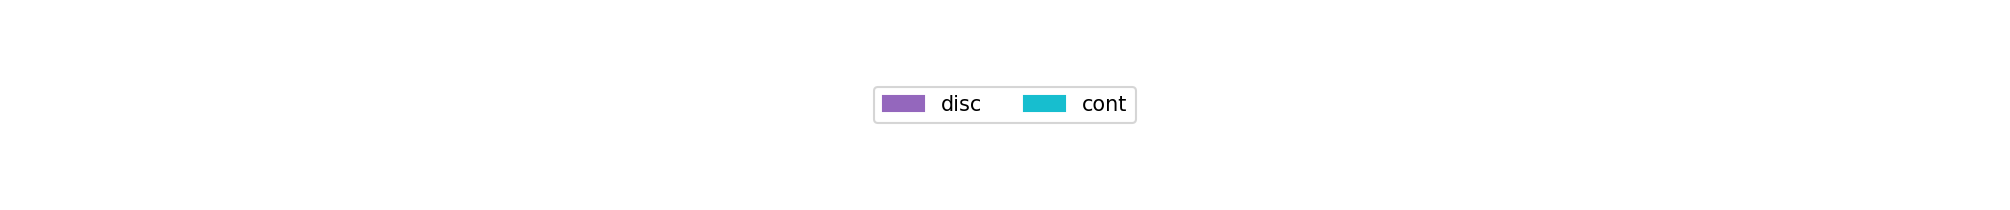

In [12]:
draw_BN(bn_geo, geo_types, 'geo_net')

In [13]:
print(bn_geo)

{'V': ['Tectonic regime', 'Period', 'Lithology', 'Structural setting', 'Hydrocarbon type', 'Gross', 'Netpay', 'Porosity', 'Permeability', 'Depth'], 'E': [['Period', 'Gross'], ['Hydrocarbon type', 'Gross'], ['Lithology', 'Gross'], ['Structural setting', 'Gross'], ['Tectonic regime', 'Gross']]}


In [1]:
params = parameter_learning(geo_train, geo_types, bn_geo)

NameError: name 'parameter_learning' is not defined

In [14]:
save_structure(bn_geo, 'geo_net')
skel = read_structure('geo_net')
save_params(params, 'geo_net_param')
params = read_params('geo_net_param')
geo_bn = HyBayesianNetwork(skel, params)

In [15]:
acc, rmse, real_data, pred_data = calculate_acc(geo_bn, geo_test, columns, 'nrmse')

In [16]:
acc

{'Tectonic regime': 0.58,
 'Period': 0.27,
 'Lithology': 0.51,
 'Structural setting': 0.31,
 'Hydrocarbon type': 0.67}

In [17]:
rmse

{'Gross': 0.2,
 'Netpay': 0.16,
 'Porosity': 0.27,
 'Permeability': 0.37,
 'Depth': 0.24}

In [54]:
for key in acc.keys():
    df_result_accuracy = df_result_accuracy.append({'Parameter': key, 'Strategy': 'evo', 'Alg':'D+M','accuracy':acc[key]}, ignore_index=True)
for key in rmse.keys():
    df_result_rmse = df_result_rmse.append({'Parameter': key, 'Strategy': 'evo', 'Alg':'D+M','rmse':rmse[key]}, ignore_index=True)

# Смешанная структура + смешанные параметры

In [18]:
bn_geo = structure_learning(geo_coded, 'evo', 'BIC', geo_types)

Cannot add to history: 'str' object has no attribute 'operation_type'
Best metric is -1.2487212634545187e-07
Generation num: 0
max_depth: 3, no improvements: 0
Number of crossover attempts exceeded. Please check composer requirements for correctness.
Number of crossover attempts exceeded. Please check composer requirements for correctness.
Number of crossover attempts exceeded. Please check composer requirements for correctness.
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.2 min
Best metric is -1.2487212634545187e-07
Generation num: 1
max_depth: 3, no improvements: 1
Number of crossover attempts exceeded. Please check composer requirements for correctness.
Number of mutation attempts exceeded. Please check composer requirements for correctness.
Number of crossover attempts exceeded. Please check composer requirements for correctness.
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.4 min
Best metric is -1.2487212

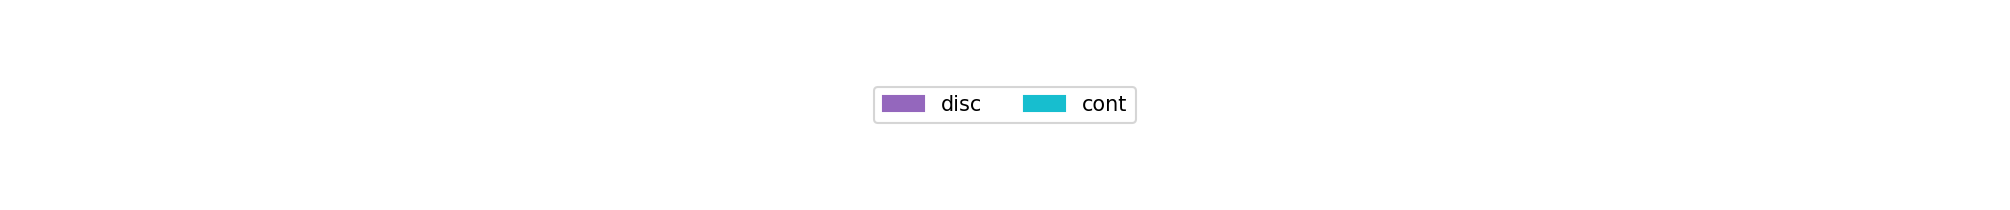

In [19]:
draw_BN(bn_geo, geo_types, 'geo_net')

In [20]:
params = parameter_learning(geo_train, geo_types, bn_geo)

In [19]:
save_structure(bn_geo, 'geo_net')
skel = read_structure('geo_net')
save_params(params, 'geo_net_param')
params = read_params('geo_net_param')
geo_bn = HyBayesianNetwork(skel, params)

In [20]:
acc, rmse, real, pred = calculate_acc(geo_bn, geo_test, columns)

7
12
21
22
27


In [21]:
acc

{'Tectonic regime': 0.58,
 'Period': 0.27,
 'Lithology': 0.51,
 'Structural setting': 0.53,
 'Hydrocarbon type': 0.67}

In [22]:
rmse

{'Gross': 403.03,
 'Netpay': 124.05,
 'Porosity': 7.67,
 'Permeability': 923.16,
 'Depth': 1293.79}

In [23]:
for key in acc.keys():
    df_result_accuracy = df_result_accuracy.append({'Parameter': key, 'Strategy': 'evo', 'Alg':'M+M','accuracy':acc[key]}, ignore_index=True)
for key in rmse.keys():
    df_result_rmse = df_result_rmse.append({'Parameter': key, 'Strategy': 'evo', 'Alg':'M+M','rmse':rmse[key]}, ignore_index=True)

# Дискретная структура + дискретные параметры

In [21]:
bn_geo = structure_learning(geo_discrete, 'evo', 'BIC', geo_new_types)

Cannot add to history: 'str' object has no attribute 'operation_type'
Best metric is -1.7252183876245725e-07
Generation num: 0
max_depth: 3, no improvements: 0
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.1 min
Best metric is -1.723830071071454e-06
Generation num: 1
max_depth: 3, no improvements: 0
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.1 min
Best metric is -1.723830071071454e-06
Generation num: 2
max_depth: 3, no improvements: 1
Number of crossover attempts exceeded. Please check composer requirements for correctness.
Number of crossover attempts exceeded. Please check composer requirements for correctness.
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.2 min
Best metric is -1.723830071071454e-06
Generation num: 3
max_depth: 3, no improvements: 2
Number of crossover attempts exceeded. Please check composer requirements for correctness.
Number of crossover attempts e

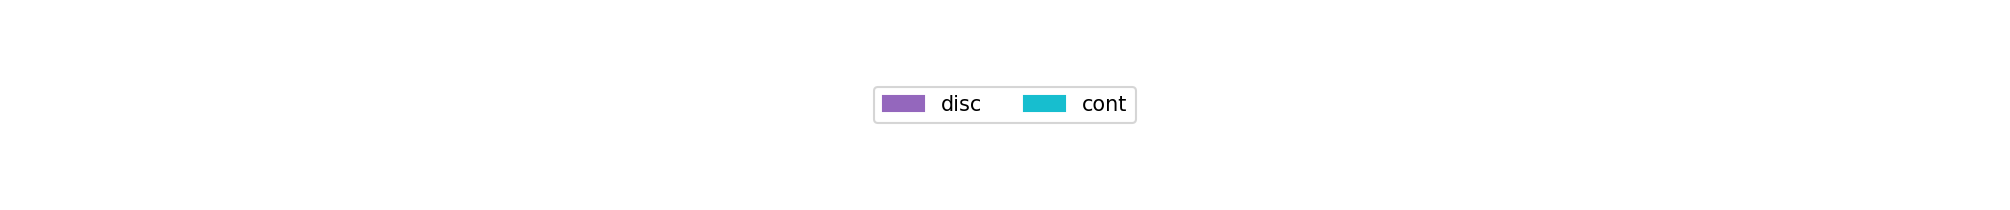

In [39]:
draw_BN(bn_geo, geo_types, 'geo_net')

In [40]:
params = parameter_learning(geo_only_discrete, geo_new_types, bn_geo)

In [41]:
save_structure(bn_geo, 'geo_net')
skel = read_structure('geo_net')
save_params(params, 'geo_net_param')
params = read_params('geo_net_param')
geo_bn = HyBayesianNetwork(skel, params)

In [42]:
test_discrete = copy(geo_test)
test_discrete[columns_for_disc] = discrete_coder.transform(geo_test[columns_for_disc].values) 

In [43]:
for c in columns_for_disc:
    test_discrete[c] = test_discrete[c].apply(lambda x: int(x))
test_discrete

,Tectonic regime,Period,Lithology,Structural setting,Hydrocarbon type,Gross,Netpay,Porosity,Permeability,Depth
0,GRAVITY,JURASSIC,LIMESTONE,SALT,OIL,1,2,4,3,2
1,EXTENSION,NEOGENE,SANDSTONE,RIFT,OIL,4,1,4,4,1
2,COMPRESSION,CRETACEOUS,SANDSTONE,FORELAND,OIL,0,0,3,1,1
3,COMPRESSION,PALEOGENE-NEOGENE,LIMESTONE,FORELAND,OIL,4,4,3,2,0
4,GRAVITY,CRETACEOUS,SANDSTONE,SALT,OIL,2,1,4,4,1
5,EXTENSION,PALEOGENE,SANDSTONE,RIFT,OIL,1,1,4,4,1
6,COMPRESSION,ORDOVICIAN,SANDSTONE,INTRACRATONIC,GAS,4,3,0,0,2
7,EXTENSION,MESOZOIC,VOLCANICS,RIFT,OIL,3,3,1,0,4
8,STRIKE-SLIP,NEOGENE,SANDSTONE,INVERSION,OIL,4,3,3,2,1
9,COMPRESSION,CRETACEOUS,LIMESTONE,SALT,OIL,2,2,3,2,1


In [44]:
acc, rmse, real, pred = calculate_acc(geo_bn, test_discrete, columns)

7
12
21
27
e:\Graphologists-master\venv\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
e:\Graphologists-master\venv\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
e:\Graphologists-master\venv\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
e:\Graphologists-master\venv\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
e:\Graphologists-master\venv\

In [45]:
acc

{'Tectonic regime': 0.58,
 'Period': 0.27,
 'Lithology': 0.31,
 'Structural setting': 0.31,
 'Hydrocarbon type': 0.67,
 'Gross': 0.0,
 'Netpay': 0.0,
 'Porosity': 0.0,
 'Permeability': 0.0,
 'Depth': 0.0}

In [46]:
for key in colums_for_code:
    df_result_accuracy = df_result_accuracy.append({'Parameter': key, 'Strategy': 'evo', 'Alg':'D+D','accuracy':acc[key]}, ignore_index=True)

In [47]:
invers_real = inverse_discretization(pd.DataFrame(np.transpose(real[5:10]), columns=['Gross', 'Netpay', 'Porosity', 'Permeability', 'Depth']), ['Gross', 'Netpay', 'Porosity', 'Permeability', 'Depth'], discrete_coder)

In [48]:
invers_pred = inverse_discretization(pd.DataFrame(np.transpose(pred[5:10]), columns=['Gross', 'Netpay', 'Porosity', 'Permeability', 'Depth']), ['Gross', 'Netpay', 'Porosity', 'Permeability', 'Depth'], discrete_coder)

In [49]:
mean_squared_error(invers_real['Gross'], invers_pred['Gross'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'Gross', 'Strategy': 'evo', 'Alg':'D+D','rmse':mean_squared_error(invers_real['Gross'], invers_pred['Gross'], squared=False)}, ignore_index=True)

In [50]:
mean_squared_error(invers_real['Netpay'], invers_pred['Netpay'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'Netpay', 'Strategy': 'evo', 'Alg':'D+D','rmse':mean_squared_error(invers_real['Netpay'], invers_pred['Netpay'], squared=False)}, ignore_index=True)

In [51]:
mean_squared_error(invers_real['Porosity'], invers_pred['Porosity'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'Porosity', 'Strategy': 'evo', 'Alg':'D+D','rmse':mean_squared_error(invers_real['Porosity'], invers_pred['Porosity'], squared=False)}, ignore_index=True)


In [52]:
mean_squared_error(invers_real['Permeability'], invers_pred['Permeability'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'Permeability', 'Strategy': 'evo', 'Alg':'D+D','rmse':mean_squared_error(invers_real['Permeability'], invers_pred['Permeability'], squared=False)}, ignore_index=True)

In [53]:
mean_squared_error(invers_real['Depth'], invers_pred['Depth'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'Depth', 'Strategy': 'evo', 'Alg':'D+D','rmse':mean_squared_error(invers_real['Depth'], invers_pred['Depth'], squared=False)}, ignore_index=True)

# Смешанная структура + дискретные параметры

In [54]:
bn_geo = structure_learning(geo_coded, 'evo', 'BIC', geo_new_types)

f
-6.199642559457041e-07
[['Porosity', 'Tectonic regime'], ['Lithology', 'Tectonic regime'], ['Structural setting', 'Tectonic regime'], ['Period', 'Tectonic regime'], ['Gross', 'Tectonic regime']]
-inf
-2.5235003365193303e+297
-inf
-inf
-6.199642559457041e-07
[['Netpay', 'Lithology'], ['Gross', 'Lithology']]
-inf
-inf
-2.5235003365193303e+297
-inf
-inf
-inf
-inf
-7.38334335319713e-10
[['Hydrocarbon type', 'Structural setting'], ['Permeability', 'Structural setting'], ['Tectonic regime', 'Structural setting']]
-inf
-inf
-inf
-inf
-inf
-inf
-4.426353147267853e-09
[['Porosity', 'Tectonic regime'], ['Lithology', 'Tectonic regime'], ['Structural setting', 'Tectonic regime'], ['Period', 'Tectonic regime'], ['Gross', 'Tectonic regime']]
-inf
-2.5235003365193303e+297
-inf
-inf
-6.199642559457041e-07
[['Porosity', 'Tectonic regime'], ['Lithology', 'Tectonic regime'], ['Structural setting', 'Tectonic regime'], ['Period', 'Tectonic regime'], ['Gross', 'Tectonic regime']]
-inf
-2.5235003365193303e

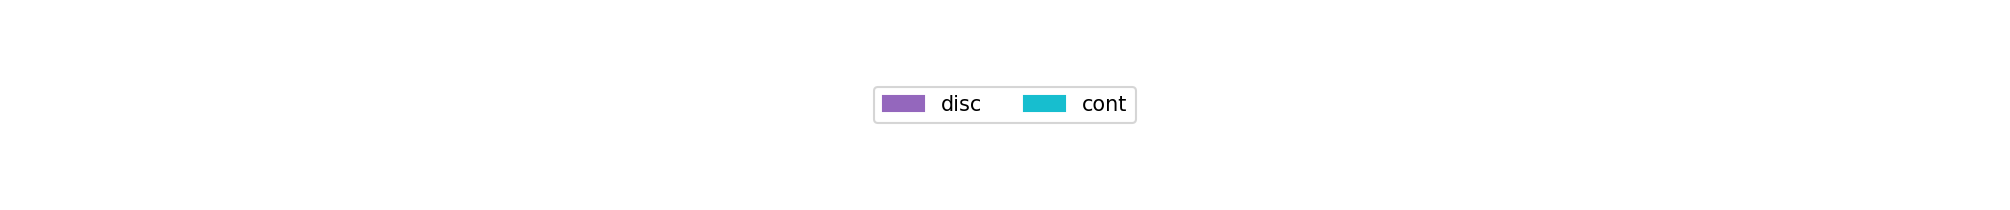

In [69]:
draw_BN(bn_geo, geo_types, 'geo_net')

In [56]:
params = parameter_learning(geo_only_discrete, geo_new_types, bn_geo)

In [57]:
save_structure(bn_geo, 'geo_net')
skel = read_structure('geo_net')
save_params(params, 'geo_net_param')
params = read_params('geo_net_param')
geo_bn = HyBayesianNetwork(skel, params)

In [58]:
acc, rmse, real, pred = calculate_acc(geo_bn, test_discrete, columns)

7
12
21
22
27
e:\Graphologists-master\venv\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
e:\Graphologists-master\venv\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
e:\Graphologists-master\venv\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
e:\Graphologists-master\venv\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
e:\Graphologists-master\ve

In [59]:
acc

{'Tectonic regime': 0.42,
 'Period': 0.27,
 'Lithology': 0.51,
 'Structural setting': 0.31,
 'Hydrocarbon type': 0.67,
 'Gross': 0.0,
 'Netpay': 0.0,
 'Porosity': 0.0,
 'Permeability': 0.0,
 'Depth': 0.0}

In [60]:
for key in colums_for_code:
    df_result_accuracy = df_result_accuracy.append({'Parameter': key, 'Strategy': 'evo', 'Alg':'M+D','accuracy':acc[key]}, ignore_index=True)

In [61]:
invers_real = inverse_discretization(pd.DataFrame(np.transpose(real[5:10]), columns=['Gross', 'Netpay', 'Porosity', 'Permeability', 'Depth']), ['Gross', 'Netpay', 'Porosity', 'Permeability', 'Depth'], discrete_coder)


In [62]:
invers_pred = inverse_discretization(pd.DataFrame(np.transpose(pred[5:10]), columns=['Gross', 'Netpay', 'Porosity', 'Permeability', 'Depth']), ['Gross', 'Netpay', 'Porosity', 'Permeability', 'Depth'], discrete_coder)

In [63]:
mean_squared_error(invers_real['Gross'], invers_pred['Gross'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'Gross', 'Strategy': 'evo', 'Alg':'M+D','rmse':mean_squared_error(invers_real['Gross'], invers_pred['Gross'], squared=False)}, ignore_index=True)

In [64]:
mean_squared_error(invers_real['Netpay'], invers_pred['Netpay'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'Netpay', 'Strategy': 'evo', 'Alg':'M+D','rmse':mean_squared_error(invers_real['Netpay'], invers_pred['Netpay'], squared=False)}, ignore_index=True)

In [65]:
mean_squared_error(invers_real['Porosity'], invers_pred['Porosity'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'Porosity', 'Strategy': 'evo', 'Alg':'M+D','rmse':mean_squared_error(invers_real['Porosity'], invers_pred['Porosity'], squared=False)}, ignore_index=True)

In [66]:
mean_squared_error(invers_real['Permeability'], invers_pred['Permeability'], squared=False)
df_result_rmse = df_result_rmse = df_result_rmse.append({'Parameter': 'Permeability', 'Strategy': 'evo', 'Alg':'M+D','rmse':mean_squared_error(invers_real['Permeability'], invers_pred['Permeability'], squared=False)}, ignore_index=True)

In [67]:
mean_squared_error(invers_real['Depth'], invers_pred['Depth'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'Depth', 'Strategy': 'evo', 'Alg':'M+D','rmse':mean_squared_error(invers_real['Depth'], invers_pred['Depth'], squared=False)}, ignore_index=True)

In [68]:
df_result_accuracy.to_csv('geo_results_disc.csv', index=False)
df_result_rmse.to_csv('geo_results_cont.csv', index=False)